<a href="https://colab.research.google.com/github/zhihong1224/CNN_Demo/blob/master/Convolutional_autoencoder_upsampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 Setup

In [0]:
import numpy as np
import torch
from torch import nn,optim
import torch.nn.functional as F
import torch.utils.data as Data
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

%matplotlib inline
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 2 准备数据

In [2]:
trans=transforms.ToTensor()
train_data_all=datasets.MNIST(root='./data',train=True,download=True,transform=trans)
test_data=datasets.MNIST(root='./data',train=False,download=True,transform=trans)
len(train_data_all),len(test_data)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


(60000, 10000)

In [0]:
indices=np.random.permutation(len(train_data_all))

valid_ratio=0.2
valid_num=int(valid_ratio*len(train_data_all))

valid_sampler=SubsetRandomSampler(indices[:valid_num])
train_sampler=SubsetRandomSampler(indices[valid_num:])

batch_size=128
valid_iter=Data.DataLoader(train_data_all,batch_size=batch_size,sampler=valid_sampler,num_workers=4)
train_iter=Data.DataLoader(train_data_all,batch_size=batch_size,sampler=train_sampler,num_workers=4)
test_iter=Data.DataLoader(test_data,batch_size=batch_size,num_workers=4)

# 3 感知数据

In [0]:
def show(data_iter,show_num):
  import math
  show_iter=iter(data_iter)
  show_some=next(show_iter)
  img,label=show_some
  rows=math.sqrt(show_num)
  cols=math.ceil(show_num/rows)
  fig=plt.figure()
  for i in range(show_num):
    ax=fig.add_subplot(rows,cols,i+1,xticks=[],yticks=[])
    ax.imshow(img[i].squeeze(0),cmap='gray')
    ax.set_title(str(label[i].item()),c='green')

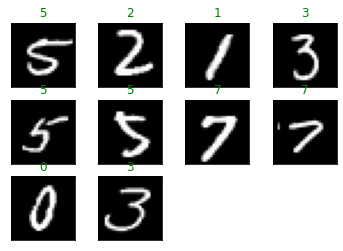

In [5]:
show(valid_iter,10)

# 4 自动编码器

In [0]:
class Autoencoder(nn.Module):
  def __init__(self):
    super(Autoencoder,self).__init__()
    self.conv1=nn.Conv2d(1,16,kernel_size=3,padding=1)
    self.conv2=nn.Conv2d(16,4,kernel_size=3,padding=1)
    self.pool=nn.MaxPool2d(2,2)

    self.conv4=nn.Conv2d(4,16,kernel_size=3,padding=1)
    self.conv5=nn.Conv2d(16,1,kernel_size=3,padding=1)
  def forward(self,x):
    x=F.relu(self.conv1(x))
    x=self.pool(x)
    x=F.relu(self.conv2(x))
    x=self.pool(x)

    x=F.upsample(x,scale_factor=2,mode='nearest')
    x=F.relu(self.conv4(x))
    x=F.upsample(x,scale_factor=2,mode='nearest')
    x=F.sigmoid(self.conv5(x))
    return x

# 5 训练

In [0]:
def train(model,num_epochs,lr,train_iter,valid_iter):
  model=model.to(device)
  criterion=nn.MSELoss()
  optimizer=optim.Adam(model.parameters(),lr)
  train_loss_list,valid_loss_list=[],[]
  valid_min_loss=np.inf

  for epoch in range(num_epochs):
    train_loss,valid_loss=0.0,0.0
    model.train()
    for X,Y in train_iter:
      X=X.to(device)
      Y=Y.to(device)
      y_pred=model(X)
      loss=criterion(y_pred,X)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      train_loss+=loss.item()*X.shape[0]
      train_loss_list.append(loss.item())
    model.eval()

    for X,Y in valid_iter:
      X=X.to(device)
      Y=Y.to(device)
      y_pred=model(X)
      loss=criterion(y_pred,X)
      valid_loss+=loss.item()*X.shape[0]
      valid_loss_list.append(loss.item())
    
    train_loss=train_loss/len(train_iter.sampler)
    valid_loss=valid_loss/len(valid_iter.sampler)

    if valid_loss<valid_min_loss:
      print('validation decreases {}-->{}.saving model...'.\
            format(valid_min_loss,valid_loss))
      torch.save(model.state_dict(),'model.pt')
    print('epoch:{},train loss:{},valid loss:{}'.\
          format(epoch+1,train_loss,valid_loss))
    print('\n')
  return train_loss_list,valid_loss_list

In [8]:
model=Autoencoder()
num_epochs,lr=5,0.001
train_loss_list,valid_loss_list=train(model,num_epochs,lr,train_iter,valid_iter)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


validation decreases inf-->0.015551250785589218.saving model...
epoch:1,train loss:0.05367662697037061,valid loss:0.015551250785589218


validation decreases inf-->0.01029630821943283.saving model...
epoch:2,train loss:0.012243780940771103,valid loss:0.01029630821943283


validation decreases inf-->0.009160487617055575.saving model...
epoch:3,train loss:0.009699417198697727,valid loss:0.009160487617055575


validation decreases inf-->0.008540683870514234.saving model...
epoch:4,train loss:0.008873916377623876,valid loss:0.008540683870514234


validation decreases inf-->0.008109595909714698.saving model...
epoch:5,train loss:0.008370080891996623,valid loss:0.008109595909714698




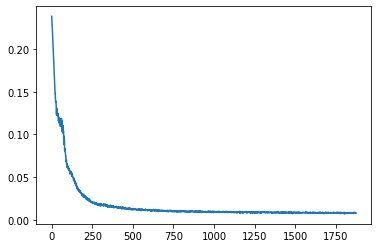

In [9]:
plt.plot(range(len(train_loss_list)),train_loss_list)
# plt.figure()
# plt.plot(range(len(valid_loss_list)),valid_loss_list)

# 6 测试

In [0]:
def check(model,data_iter,show_num):
  import math
  show_iter=iter(data_iter)
  show_some=next(show_iter)
  img,label=show_some
  decoder=model(img.to(device))
  fig=plt.figure()
  for i in range(show_num):
    ax=fig.add_subplot(2,show_num,i+1,xticks=[],yticks=[])
    ax.imshow(img[i].squeeze(0).numpy(),cmap='gray')
    ax=fig.add_subplot(2,show_num,show_num+i+1,xticks=[],yticks=[])
    ax.imshow(decoder[i].squeeze(0).cpu().detach().numpy(),cmap='gray')

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


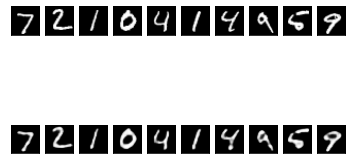

In [11]:
model.load_state_dict(torch.load('model.pt'))
check(model,test_iter,10)